# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [3]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [4]:
import re
from random import shuffle
from glob import glob

train_files = glob('catdog/train/*.jpg')
test_files = glob('catdog/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*dog\.\d+.*', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

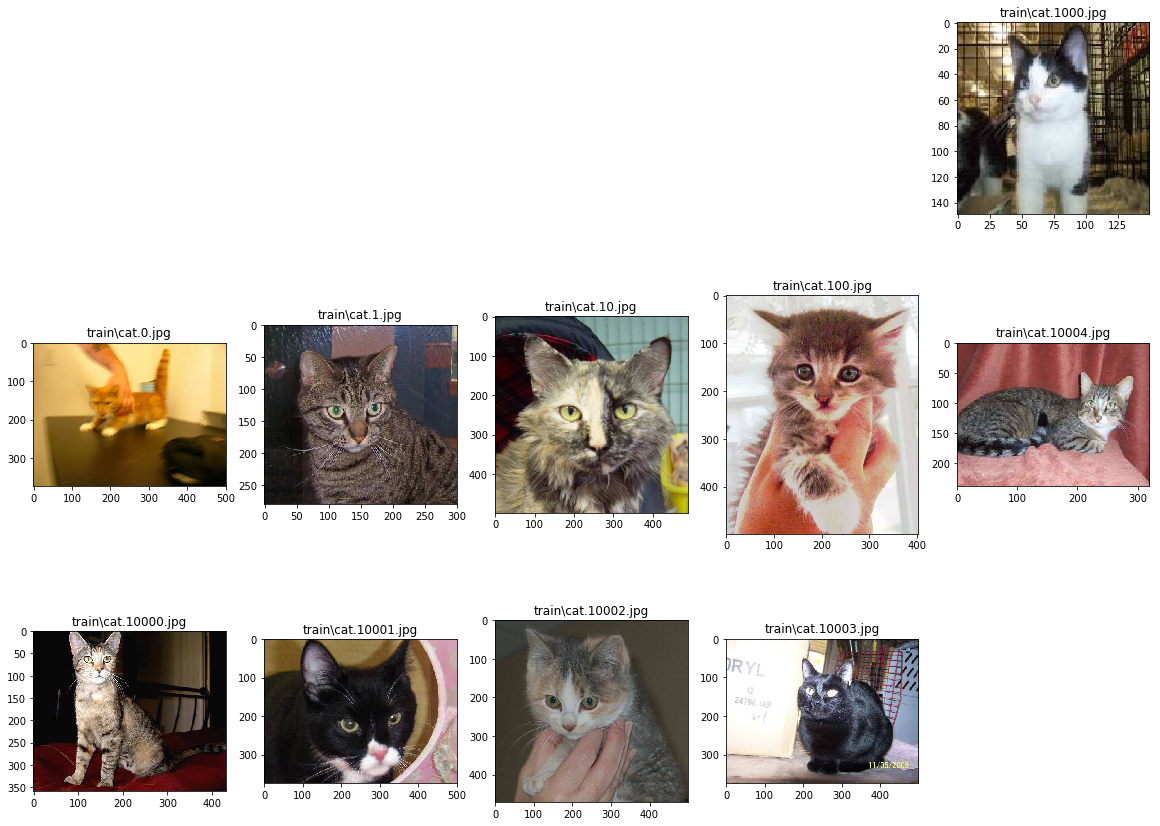

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [6]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [7]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

## Добавляем полносвязный слой

In [8]:
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Компилируем модель и запускаем обучение

In [14]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [15]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
                    steps_per_epoch=3,  # число вызовов генератора за эпоху
                    epochs=5,  # число эпох обучения
                    validation_data=validation_data)

Epoch 1/5
3/3 [==============================] - 210s - loss: 0.5634 - acc: 0.9583 - val_loss: 0.3477 - val_acc: 0.9700
Epoch 2/5
3/3 [==============================] - 209s - loss: 0.0715 - acc: 0.9896 - val_loss: 0.3141 - val_acc: 0.9600
Epoch 3/5
3/3 [==============================] - 210s - loss: 0.2003 - acc: 0.9688 - val_loss: 0.3313 - val_acc: 0.9800
Epoch 4/5
3/3 [==============================] - 240s - loss: 0.4545 - acc: 0.9583 - val_loss: 0.2943 - val_acc: 0.9700
Epoch 5/5
3/3 [==============================] - 227s - loss: 0.3541 - acc: 0.9583 - val_loss: 0.5747 - val_acc: 0.9500


## Предсказания на проверочной выборке

In [24]:
test_files = glob('catdog/test_all/*.jpg')


In [25]:

pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=100)
# test_files[80:][:10], pred[80:][:10]

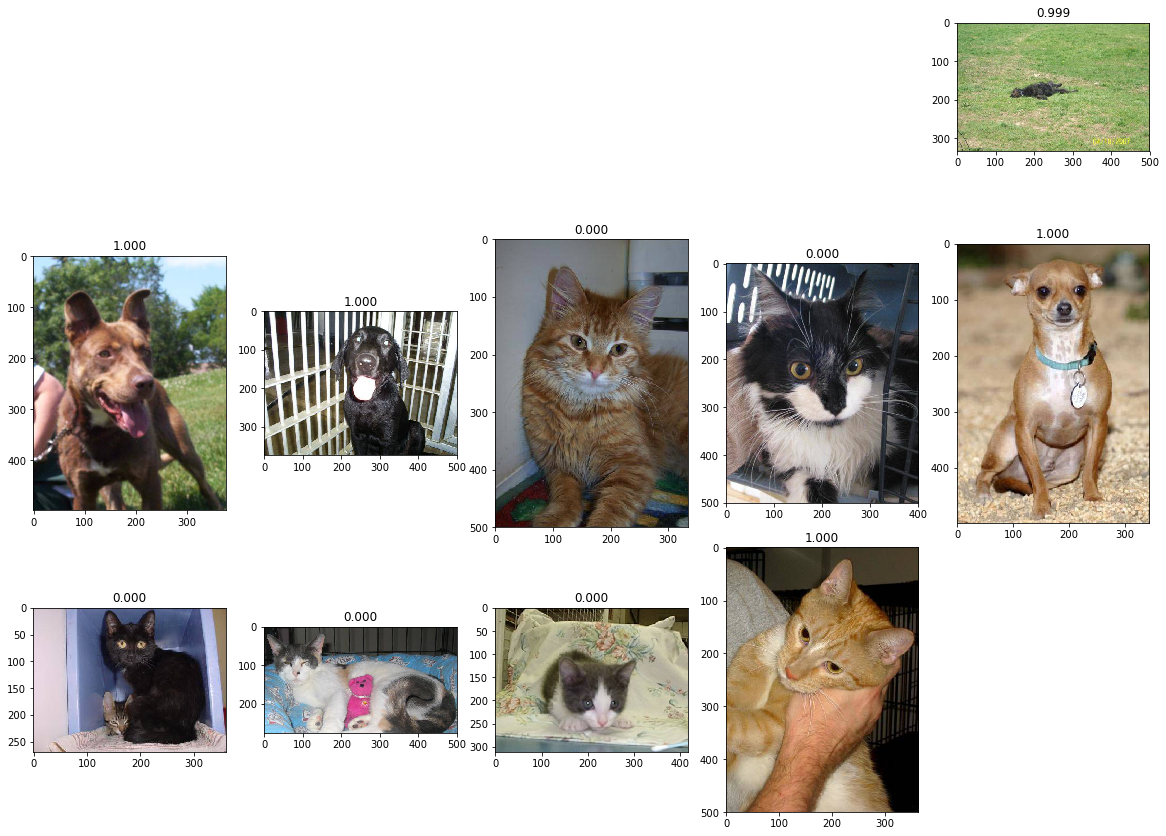

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [38]:
with open('submit_03.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [ ]:
# LogLoss = 1.04979